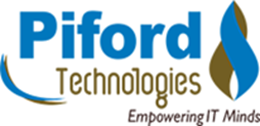


# Testing Custom Mask R-CNN Model

In [1]:
import warnings
warnings.filterwarnings('ignore')
import os
import sys
import json
import datetime
import numpy as np
import skimage.draw
import cv2
import random
import math
import re
import time
import tensorflow as tf
import matplotlib.pyplot as plt
import matplotlib.patches as patches
import matplotlib.image as mpimg

from mrcnn import utils
from mrcnn import visualize
from mrcnn.visualize import display_images
from mrcnn.visualize import display_instances
import mrcnn.model as modellib
from mrcnn.model import log
from mrcnn.config import Config
from mrcnn import model as modellib, utils

#import custom

# Root directory of the project
ROOT_DIR = "/mnt/g/Evaluating-the-Value-of-Wood-Panel/"                                                              #Change

DEFAULT_LOGS_DIR = os.path.join(ROOT_DIR, "logs")

MODEL_DIR = os.path.join(ROOT_DIR, "logs")


WEIGHTS_PATH = "/mnt/g/Evaluating-the-Value-of-Wood-Panel/mask_rcnn_object_0004.h5"                            #Change


Using TensorFlow backend.


In [2]:
class CustomConfig(Config):
    """Configuration for training on the custom  dataset.
    Derives from the base Config class and overrides some values.
    """
    # Give the configuration a recognizable name
    NAME = "object"

    IMAGES_PER_GPU = 1

    NUM_CLASSES = 1 + 2  # Background + Car and truck                                                                                   #Change

    # Number of training steps per epoch
    STEPS_PER_EPOCH = 10

    # Skip detections with < 90% confidence
    DETECTION_MIN_CONFIDENCE = 0.9

In [3]:
class CustomDataset(utils.Dataset):

    def load_custom(self, dataset_dir, subset):
        """Load a subset of the Dog-Cat dataset.
        dataset_dir: Root directory of the dataset.
        subset: Subset to load: train or val
        """
        # Add classes. We have only one class to add.                                                                               #Change
        self.add_class("object", 1, "knotHole")
        self.add_class("object", 2, "pinKnot")

        # Train or validation dataset?
        assert subset in ["train", "val"]
        dataset_dir = os.path.join(dataset_dir, subset)

        # We mostly care about the x and y coordinates of each region
        annotations1 = json.load(open(os.path.join(dataset_dir,subset+'.json')))                                                  #Changed to use function arguments
        # print(annotations1)
        annotations = list(annotations1.values())  # don't need the dict keys

        # The VIA tool saves images in the JSON even if they don't have any
        # annotations. Skip unannotated images.
        annotations = [a for a in annotations if a['regions']]
        
        # Add images
        for a in annotations:
            # print(a)
            # Get the x, y coordinaets of points of the polygons that make up
            # the outline of each object instance. There are stores in the
            # shape_attributes (see json format above)
            polygons = [r['shape_attributes'] for r in a['regions']] 
            objects = [s['region_attributes']['defects'] for s in a['regions']]                                                     #Change, from 'names' to 'defects'
            print("objects:",objects)
            name_dict = {"knotHole": 1,"pinKnot": 2}                                                                                #Change

            # key = tuple(name_dict)
            num_ids = [name_dict[a] for a in objects]
     
            # num_ids = [int(n['Event']) for n in objects]
            # load_mask() needs the image size to convert polygons to masks.
            # Unfortunately, VIA doesn't include it in JSON, so we must read
            # the image. This is only managable since the dataset is tiny.
            print("numids",num_ids)
            image_path = os.path.join(dataset_dir, a['filename'])
            image = skimage.io.imread(image_path)
            height, width = image.shape[:2]

            self.add_image(
                "object",  ## for a single class just add the name here
                image_id=a['filename'],  # use file name as a unique image id
                path=image_path,
                width=width, height=height,
                polygons=polygons,
                num_ids=num_ids
                )

    def load_mask(self, image_id):
        """Generate instance masks for an image.
       Returns:
        masks: A bool array of shape [height, width, instance count] with
            one mask per instance.
        class_ids: a 1D array of class IDs of the instance masks.
        """
        # If not a Dog-Cat dataset image, delegate to parent class.
        image_info = self.image_info[image_id]
        if image_info["source"] != "object":
            return super(self.__class__, self).load_mask(image_id)

        # Convert polygons to a bitmap mask of shape
        # [height, width, instance_count]
        info = self.image_info[image_id]
        if info["source"] != "object":
            return super(self.__class__, self).load_mask(image_id)
        num_ids = info['num_ids']
        mask = np.zeros([info["height"], info["width"], len(info["polygons"])],
                        dtype=np.uint8)
        for i, p in enumerate(info["polygons"]):
            # Get indexes of pixels inside the polygon and set them to 1
        	rr, cc = skimage.draw.polygon(p['all_points_y'], p['all_points_x'])

        	mask[rr, cc, i] = 1

        # Return mask, and array of class IDs of each instance. Since we have
        # one class ID only, we return an array of 1s
        # Map class names to class IDs.
        num_ids = np.array(num_ids, dtype=np.int32)
        return mask, num_ids #np.ones([mask.shape[-1]], dtype=np.int32)

    def image_reference(self, image_id):
        """Return the path of the image."""
        info = self.image_info[image_id]
        if info["source"] == "object":
            return info["path"]
        else:
            super(self.__class__, self).image_reference(image_id)

In [5]:
# Inspect the model in training or inference modes values: 'inference' or 'training'
TEST_MODE = "inference"
ROOT_DIR = "/mnt/g/Evaluating-the-Value-of-Wood-Panel/Dataset"                                                                       #Change to Dataset Folder

def get_ax(rows=1, cols=1, size=16):
  """Return a Matplotlib Axes array to be used in all visualizations in the notebook.  Provide a central point to control graph sizes. Adjust the size attribute to control how big to render images"""
  _, ax = plt.subplots(rows, cols, figsize=(size*cols, size*rows))
  return ax



# Load validation dataset
# Must call before using the dataset
CUSTOM_DIR = "/mnt/g/Evaluating-the-Value-of-Wood-Panel/Dataset"                                                                     #Change to Dataset Folder
dataset = CustomDataset()
dataset.load_custom(CUSTOM_DIR, "val")
dataset.prepare()
print("Images: {}\nClasses: {}".format(len(dataset.image_ids), dataset.class_names))

objects: ['knotHole', 'knotHole', 'knotHole', 'knotHole', 'knotHole', 'knotHole', 'pinKnot']
numids [1, 1, 1, 1, 1, 1, 2]
objects: ['knotHole', 'knotHole', 'knotHole', 'knotHole', 'knotHole', 'knotHole', 'knotHole', 'knotHole', 'knotHole', 'pinKnot', 'pinKnot', 'pinKnot', 'pinKnot', 'pinKnot', 'knotHole']
numids [1, 1, 1, 1, 1, 1, 1, 1, 1, 2, 2, 2, 2, 2, 1]
objects: ['knotHole', 'knotHole', 'pinKnot', 'pinKnot', 'pinKnot', 'pinKnot', 'pinKnot', 'pinKnot', 'pinKnot', 'pinKnot', 'pinKnot', 'pinKnot', 'pinKnot', 'pinKnot', 'pinKnot', 'pinKnot', 'pinKnot', 'pinKnot', 'pinKnot', 'pinKnot', 'pinKnot', 'pinKnot', 'knotHole', 'knotHole', 'knotHole', 'knotHole', 'knotHole', 'knotHole']
numids [1, 1, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 1, 1, 1, 1, 1, 1]
Images: 3
Classes: ['BG', 'knotHole', 'pinKnot']


In [6]:
config = CustomConfig()
#LOAD MODEL. Create model in inference mode
model = modellib.MaskRCNN(mode="inference", model_dir=MODEL_DIR, config=config)






Instructions for updating:
keep_dims is deprecated, use keepdims instead
Instructions for updating:
keep_dims is deprecated, use keepdims instead

Instructions for updating:
Use tf.where in 2.0, which has the same broadcast rule as np.where
Instructions for updating:
box_ind is deprecated, use box_indices instead


Instructions for updating:
Use `tf.cast` instead.


In [7]:
# Load COCO weights Or, load the last model you trained
weights_path = WEIGHTS_PATH
# Load weights
print("Loading weights ", weights_path)
model.load_weights(weights_path, by_name=True)

Loading weights  /mnt/g/Evaluating-the-Value-of-Wood-Panel/mask_rcnn_object_0004.h5


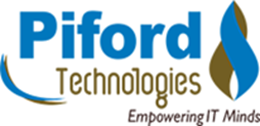

Images: 3
Classes: ['BG', 'knotHole', 'pinKnot']
Processing 1 images
image                    shape: (1500, 2448, 3)       min:    0.00000  max:  255.00000  uint8
molded_images            shape: (1, 1024, 1024, 3)    min: -123.70000  max:  151.10000  float64
image_metas              shape: (1, 15)               min:    0.00000  max: 2448.00000  float64
anchors                  shape: (1, 261888, 4)        min:   -0.35390  max:    1.29134  float32


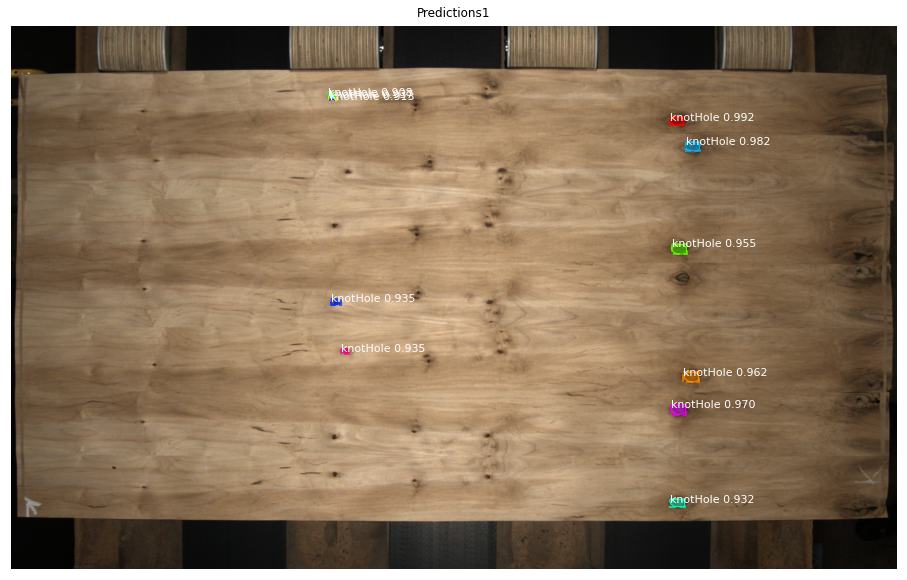

In [8]:

print("Images: {}\nClasses: {}".format(len(dataset.image_ids), dataset.class_names))

# This is for predicting images which are not present in dataset
path_to_new_image = '/mnt/g/Evaluating-the-Value-of-Wood-Panel/test.bmp'                                                            #Change to unlabeled image
image1 = mpimg.imread(path_to_new_image)

# Run object detection
#print(len([image1]))
results1 = model.detect([image1], verbose=1)

# Display results
ax = get_ax(1)
r1 = results1[0]
visualize.display_instances(image1, r1['rois'], r1['masks'], r1['class_ids'],
dataset.class_names, r1['scores'], ax=ax, title="Predictions1")





In [14]:
#RUN DETECTION
image_id = random.choice(dataset.image_ids)
#image_id = 'D:/MaskRCNN-aar/Dataset/val/1.jfif'
print("image id is :",image_id)
image, image_meta, gt_class_id, gt_bbox, gt_mask =\
modellib.load_image_gt(dataset, config, image_id, use_mini_mask=False)
info = dataset.image_info[image_id]
print("image ID: {}.{} ({}) {}".format(info["source"], info["id"], image_id,dataset.image_reference(image_id)))

# Run object detection
results = model.detect([image], verbose=1)


image id is : 2
image ID: object.knotHole (43).bmp (2) /mnt/g/Evaluating-the-Value-of-Wood-Panel/Dataset/val/knotHole (43).bmp
Processing 1 images
image                    shape: (1024, 1024, 3)       min:    0.00000  max:  255.00000  uint8
molded_images            shape: (1, 1024, 1024, 3)    min: -123.70000  max:  151.10000  float64
image_metas              shape: (1, 15)               min:    0.00000  max: 1024.00000  int64
anchors                  shape: (1, 261888, 4)        min:   -0.35390  max:    1.29134  float32


gt_class_id              shape: (27,)                 min:    1.00000  max:    2.00000  int32
gt_bbox                  shape: (27, 4)               min:   53.00000  max:  768.00000  int32
gt_mask                  shape: (1024, 1024, 27)      min:    0.00000  max:    1.00000  uint8


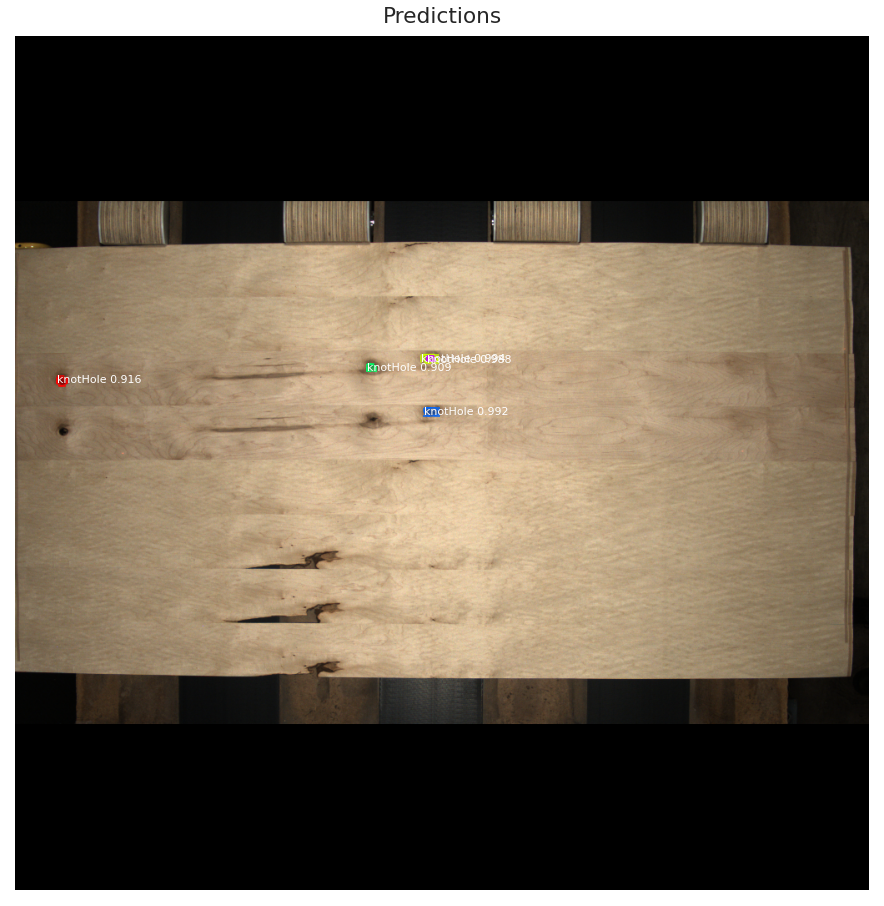

In [15]:
x = get_ax(1)
r = results[0]
ax = plt.gca()
visualize.display_instances(image, r['rois'], r['masks'], r['class_ids'], dataset.class_names, r['scores'], ax=ax, title="Predictions")
log("gt_class_id", gt_class_id)
log("gt_bbox", gt_bbox)
log("gt_mask", gt_mask)

# mean average precision

In [16]:
import utils


total_gt = np.array([]) 
total_pred = np.array([]) 
mAP_ = [] #mAP list

#compute total_gt, total_pred and mAP for each image in the test dataset
# Compute total ground truth boxes(total_gt) and total predicted boxes(total_pred) and mean average precision for each Image 
#in the test dataset
for image_id in dataset.image_ids:
    image, image_meta, gt_class_id, gt_bbox, gt_mask =modellib.load_image_gt(dataset, config, image_id)#, #use_mini_mask=False)
    info = dataset.image_info[image_id]

    # Run the model
    results = model.detect([image], verbose=1)
    r = results[0]
    
    #compute gt_tot and pred_tot
    gt, pred = utils.gt_pred_lists(gt_class_id, gt_bbox, r['class_ids'], r['rois'])
    total_gt = np.append(total_gt, gt)
    total_pred = np.append(total_pred, pred)
    
    #precision_, recall_, AP_ 
    AP_, precision_, recall_, overlap_ = utils.compute_ap(gt_bbox, gt_class_id, gt_mask,
                                          r['rois'], r['class_ids'], r['scores'], r['masks'])
    #check if the vectors len are equal
    print("the actual length of the ground truth vect is : ", len(total_gt))
    print("the actual length of the predicted vect is : ", len(total_pred))
    
    mAP_.append(AP_)
    print("Average precision of this image : ",AP_)
    print("The actual mean average precision for the whole images", sum(mAP_)/len(mAP_))

import pandas as pd
total_gt=total_gt.astype(int)
total_pred=total_pred.astype(int)
#save the vectors of gt and pred
save_dir = "output"
gt_pred_tot_json = {"Total Groundtruth" : total_gt, "predicted box" : total_pred}
df = pd.DataFrame(gt_pred_tot_json)
if not os.path.exists(save_dir):
    os.makedirs(save_dir)
df.to_json(os.path.join(save_dir,"gt_pred_test.json"))


Processing 1 images
image                    shape: (1024, 1024, 3)       min:    0.00000  max:  255.00000  uint8
molded_images            shape: (1, 1024, 1024, 3)    min: -123.70000  max:  151.10000  float64
image_metas              shape: (1, 15)               min:    0.00000  max: 1024.00000  int64
anchors                  shape: (1, 261888, 4)        min:   -0.35390  max:    1.29134  float32
the actual length of the ground truth vect is :  8
the actual length of the predicted vect is :  8
Average precision of this image :  0.0
The actual mean average precision for the whole images 0.0
Processing 1 images
image                    shape: (1024, 1024, 3)       min:    0.00000  max:  255.00000  uint8
molded_images            shape: (1, 1024, 1024, 3)    min: -123.70000  max:  150.10000  float64
image_metas              shape: (1, 15)               min:    0.00000  max: 1024.00000  int64
anchors                  shape: (1, 261888, 4)        min:   -0.35390  max:    1.29134  float32
the

# Confusion Matrix

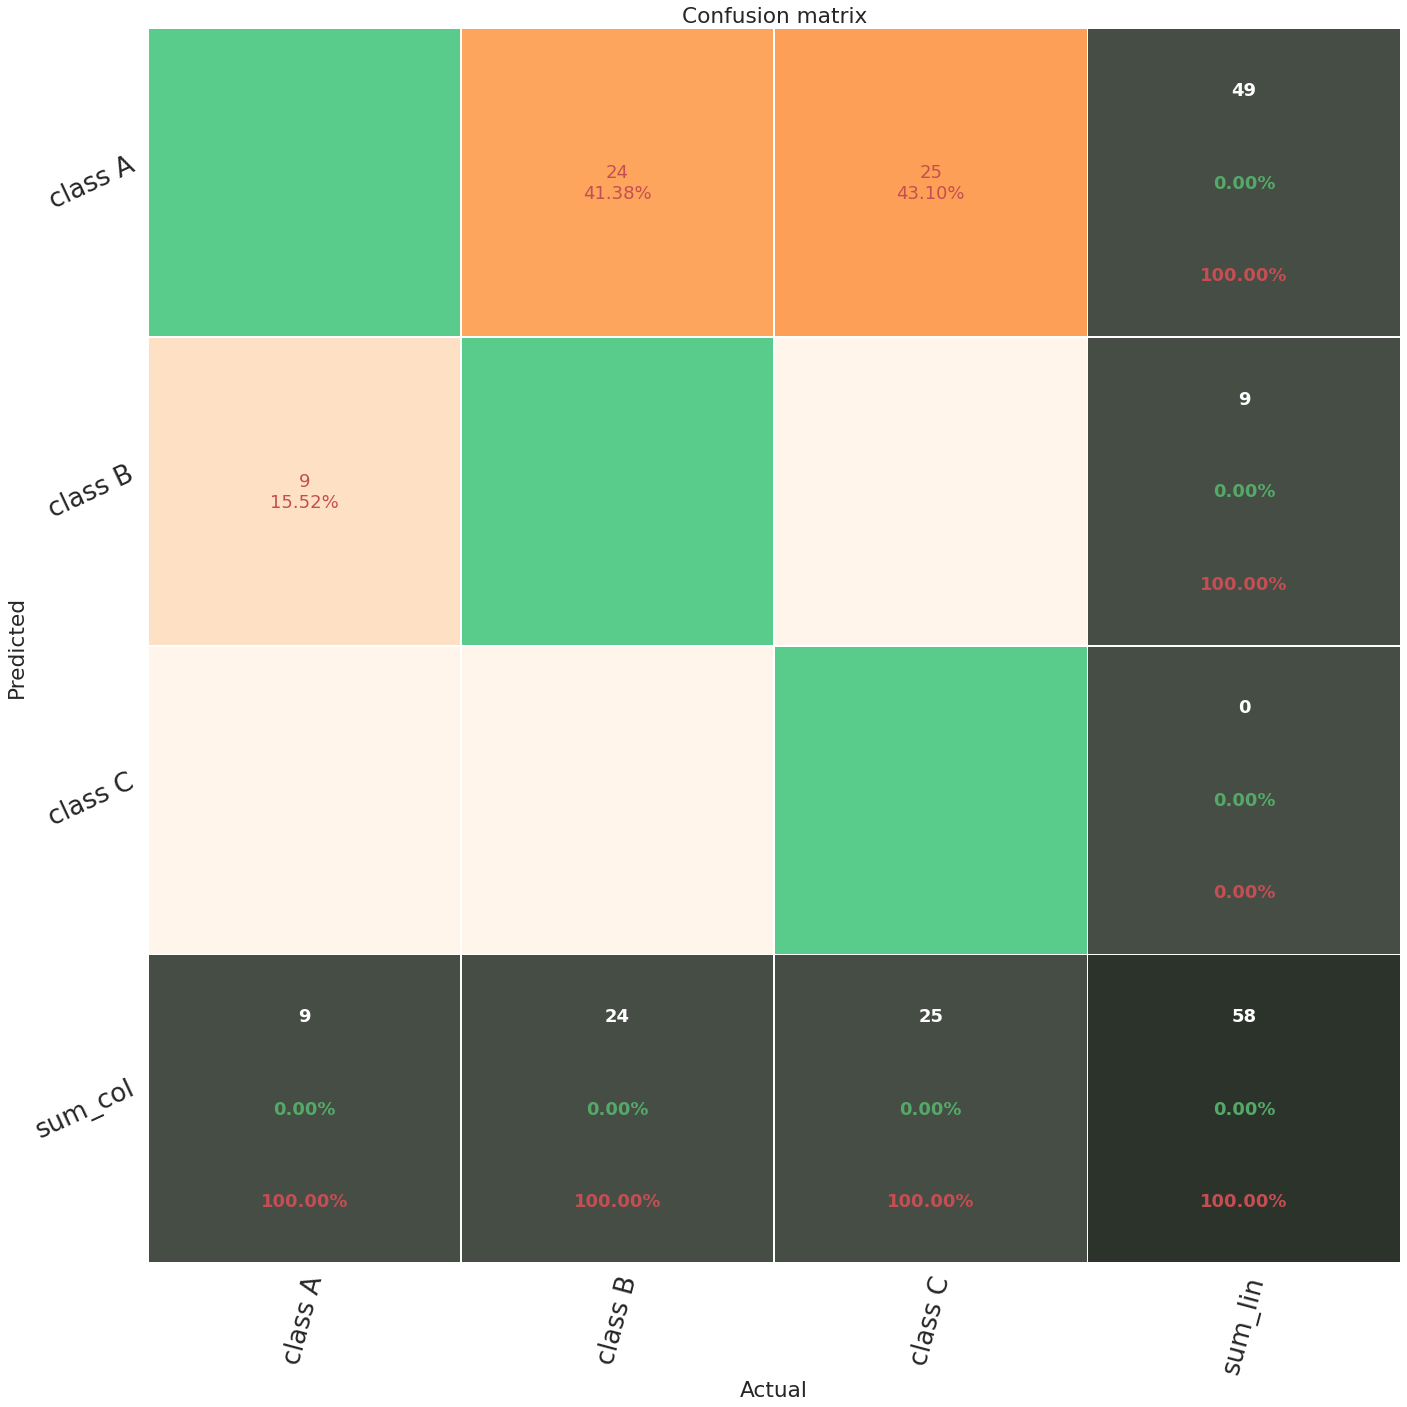

In [17]:
tp,fp,fn=utils.plot_confusion_matrix_from_data(total_gt,total_pred,fz=18, figsize=(20,20), lw=0.5)
#The vertical axis represent the ground-truth classes and the horizontal axis represent the predicted classes.
#BG class is the background class.
# It is not taken into account in the calculation of the mAP.

In [13]:
print("tp for each class :",tp)
print("fp for each class :",fp)
print("fn for each class :",fn)

#eliminate the background class (class A) from tps fns and fns lists since it doesn't concern us anymore : 
del tp[0]
del fp[0]
del fn[0]
print("\n########################\n")
print("tp for each class :",tp)
print("fp for each class :",fp)
print("fn for each class :",fn)

tp for each class : [0, 0, 0]
fp for each class : [9, 24, 25]
fn for each class : [49, 9, 0]

########################

tp for each class : [0, 0]
fp for each class : [24, 25]
fn for each class : [9, 0]
